In [1]:
"""
Explore more of the JIC header
"""

import os
import sys
from collections import namedtuple

import numpy as np
import matplotlib.pyplot as plt
from crccheck.crc import Crc16Modbus

sys.path.append("../extract_pin_addr")
from JicBitstream import JicBitstream, JicBitstreamZip

%matplotlib notebook

In [2]:
MAGIC_SIZE = 4
HEADER_SIZE = 77660
BLK_SIZE = 1188

In [3]:
filenames = [
    "../../bitstreams/ref/factory.jic",
    "../../bitstreams/comp/T31_output_addr_0x100000.jic",
    "../../bitstreams/comp/T31_output_addr_0x100000_comp.jic",
    "../../bitstreams/comp/T31_output_addr_0x200000.jic",
    "../../bitstreams/comp/T31_output_addr_0x200000_comp.jic",
]

FileInfo = namedtuple("FileInfo", ["block_loc_start", "last_block_start", "nr_blocks"])

file_info = dict()

In [4]:
for filename in filenames:
    jic_bs = JicBitstream(filename)
    jic = jic_bs.jic_uint8
    starts = jic_bs.find_jjjj_seqs()

    print(f"Analyzing {os.path.basename(filename)}")

    for start in starts:
        print(f"  Start address: 0x{start:06x}")

        magic = jic[start : start + MAGIC_SIZE]
        header = jic[start + MAGIC_SIZE : start + MAGIC_SIZE + HEADER_SIZE]
        block_loc_start = start + MAGIC_SIZE + HEADER_SIZE

        cur_block_start = block_loc_start
        last_block_start = None

        while True:
            data = jic[cur_block_start : cur_block_start + BLK_SIZE]
            checksum = Crc16Modbus.calc(data)

            # print(f"Calculating CRC for block 0x{cur_block_start:06x}", end="")
            # print(f", checksum = {checksum:04x}")

            if checksum == 0:
                cur_block_start += BLK_SIZE
            else:
                last_block_start = cur_block_start
                break

        nr_blocks = (last_block_start - block_loc_start) // BLK_SIZE
        print(f"  nr blocks = {nr_blocks}")

        file_info[filename] = FileInfo(
            block_loc_start=block_loc_start,
            last_block_start=last_block_start,
            nr_blocks=nr_blocks,
        )

Analyzing factory.jic
  Start address: 0x000134
  nr blocks = 58
  Start address: 0x1000134
  nr blocks = 58
Analyzing T31_output_addr_0x100000.jic
  Start address: 0x100122
  nr blocks = 96
Analyzing T31_output_addr_0x100000_comp.jic
  Start address: 0x100122
  nr blocks = 58
Analyzing T31_output_addr_0x200000.jic
  Start address: 0x200122
  nr blocks = 96
Analyzing T31_output_addr_0x200000_comp.jic
  Start address: 0x200122
  nr blocks = 58


In [5]:
def decimate(orig, N):
    M = orig.shape[0] // N
    orig = orig[0 : N * M]
    orig = orig.reshape((M, N))
    dec = np.sum(orig, axis=1)
    return dec

def plot_bitstream(ax, filename, N=1, lower_lim=None, upper_lim=None, bits=False):
    """ Plot bitstream (pop count)

    Arguments
        N: decimation factor
    """

    bitstream = JicBitstream(filename)

    if bits:
        jic = bitstream.jic.reshape(-1)
        if lower_lim is not None:
            lower_lim *= 8
        if upper_lim is not None:
            upper_lim *= 8
    else:
        jic = bitstream.jic_uint8.reshape(-1)

    if lower_lim is not None and upper_lim is not None:
        jic = jic[lower_lim:upper_lim]
    elif lower_lim is not None:
        upper_lim = jic.shape[0]
        jic = jic[lower_lim:]
    elif upper_lim is not None:
        lower_lim = 0
        jic = jic[0:upper_lim]
    else:
        lower_lim = 0
        upper_lim = jic.shape[0]

    dec = decimate(jic, N)
    x = np.linspace(lower_lim, upper_lim, len(dec))

    ax.plot(x, dec, label=os.path.basename(filename))

<IPython.core.display.Javascript object>


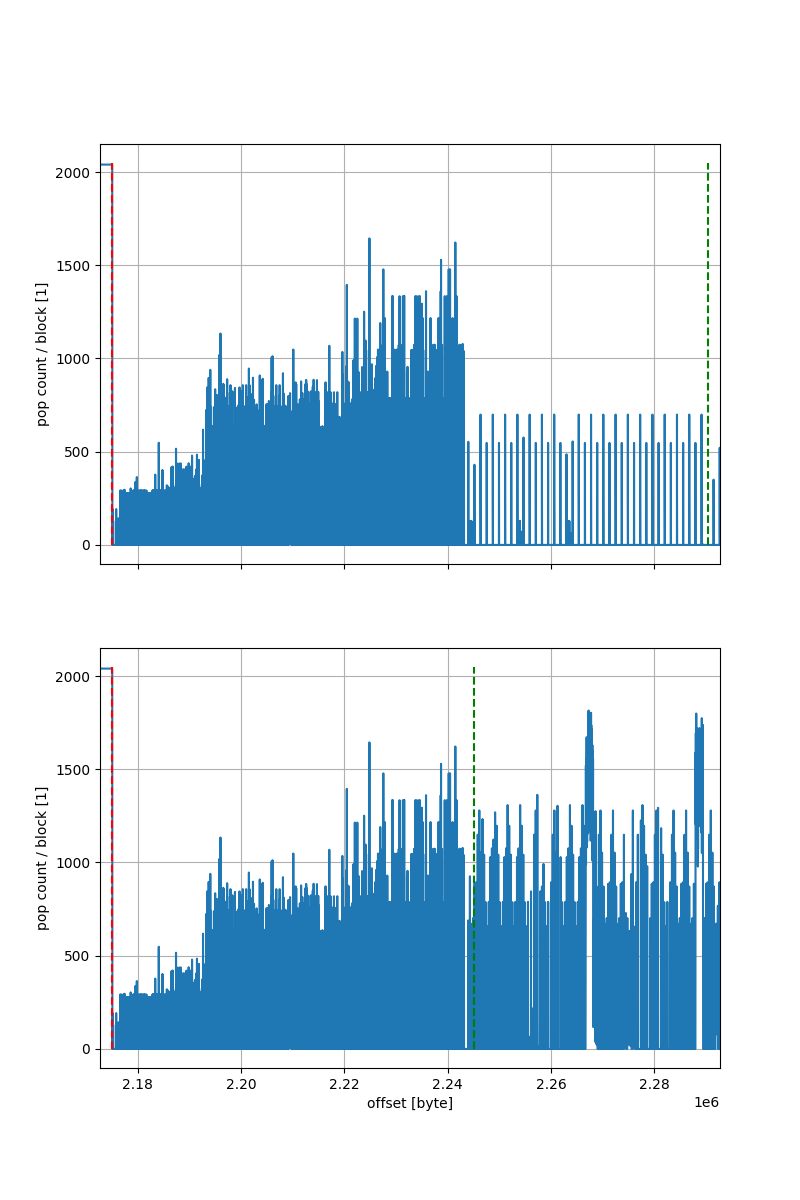

In [6]:
fig = plt.figure(figsize=(8, 12))
ax1, ax2 = fig.subplots(2, 1, sharex=True)

N = 8
fn1 = "../../bitstreams/comp/T31_output_addr_0x200000.jic"
fn2 = "../../bitstreams/comp/T31_output_addr_0x200000_comp.jic"

plot_bitstream(ax1, fn1, N=N)
plot_bitstream(ax2, fn2, N=N)

ax1.plot(
    [file_info[fn1].block_loc_start, file_info[fn1].block_loc_start],
    [0, 256 * N],
    "--r",
)
ax1.plot(
    [
        file_info[fn1].last_block_start + BLK_SIZE,
        file_info[fn1].last_block_start + BLK_SIZE,
    ],
    [0, 256 * N],
    "--g",
)

ax2.plot(
    [file_info[fn2].block_loc_start, file_info[fn2].block_loc_start],
    [0, 256 * N],
    "--r",
)
ax2.plot(
    [
        file_info[fn2].last_block_start + BLK_SIZE,
        file_info[fn2].last_block_start + BLK_SIZE,
    ],
    [0, 256 * N],
    "--g",
)

ax1.grid()
ax1.set_ylabel("pop count / block [1]")
ax2.grid()
ax2.set_ylabel("pop count / block [1]")
ax2.set_xlabel("offset [byte]")


ax2.set_xlim(
    (
        min(file_info[fn1].block_loc_start, file_info[fn2].block_loc_start)
        - 2 * BLK_SIZE,
        max(
            file_info[fn1].last_block_start + BLK_SIZE,
            file_info[fn2].last_block_start + BLK_SIZE,
        )
        + 2 * BLK_SIZE,
    )
)


None

In [7]:
fn1 = "../../bitstreams/comp/T31_output_addr_0x200000.jic"

fi = file_info[fn1]
jic = JicBitstream(fn1).jic_uint8

print(jic[fi.last_block_start-4:fi.last_block_start+4])
fi

[  0   0  47 232 193 104   3   0]


FileInfo(block_loc_start=2175106, last_block_start=2289154, nr_blocks=96)

In [8]:
vhex = np.vectorize(hex)

for filename in filenames:
    jic_bs = JicBitstream(filename)
    jic = jic_bs.jic_uint8
    starts = jic_bs.find_jjjj_seqs()

    print(f"Analyzing {os.path.basename(filename)}")

    for start in starts:
        print(f"  Start address: 0x{start:06x}")

        magic = jic[start : start + MAGIC_SIZE]
        header = jic[start + MAGIC_SIZE : start + MAGIC_SIZE + HEADER_SIZE]
        block_loc_start = start + MAGIC_SIZE + HEADER_SIZE

        cur_block_start = block_loc_start
        last_block_start = None

        while True:
            data = jic[cur_block_start : cur_block_start + BLK_SIZE]
            checksum = Crc16Modbus.calc(data)
            if np.any(data[0:4] != 0):
                print(cur_block_start, vhex(data[0:6]), checksum)

            # print(f"Calculating CRC for block 0x{cur_block_start:06x}", end="")
            # print(f", checksum = {checksum:04x}")

            if checksum == 0:
                cur_block_start += BLK_SIZE
            else:
                last_block_start = cur_block_start
                break

        nr_blocks = (last_block_start - block_loc_start) // BLK_SIZE
        print(f"  nr blocks = {nr_blocks}")

        file_info[filename] = FileInfo(
            block_loc_start=block_loc_start,
            last_block_start=last_block_start,
            nr_blocks=nr_blocks,
        )

Analyzing factory.jic
  Start address: 0x000134
145688 ['0x2a' '0xc5' '0x1' '0x0' '0x0' '0x80'] 0
146876 ['0x4f' '0xe8' '0x13' '0x1' '0x0' '0x0'] 31405
  nr blocks = 58
  Start address: 0x1000134
16922904 ['0x2a' '0xc5' '0x1' '0x0' '0x0' '0x80'] 0
16924092 ['0x4f' '0xe8' '0x13' '0x1' '0x0' '0x0'] 54968
  nr blocks = 58
Analyzing T31_output_addr_0x100000.jic
  Start address: 0x100122
1194246 ['0x2a' '0xc5' '0x1' '0x0' '0x0' '0x0'] 0
1195434 ['0x84' '0x3e' '0x1' '0x0' '0x0' '0x0'] 0
1240578 ['0xc1' '0x68' '0x3' '0x0' '0x0' '0x0'] 44632
  nr blocks = 96
Analyzing T31_output_addr_0x100000_comp.jic
  Start address: 0x100122
1194246 ['0x2a' '0xc5' '0x1' '0x0' '0x0' '0x0'] 0
1195434 ['0x4f' '0xe8' '0x13' '0x1' '0x0' '0x0'] 36558
  nr blocks = 58
Analyzing T31_output_addr_0x200000.jic
  Start address: 0x200122
2242822 ['0x2a' '0xc5' '0x1' '0x0' '0x0' '0x0'] 0
2244010 ['0x84' '0x3e' '0x1' '0x0' '0x0' '0x0'] 0
2289154 ['0xc1' '0x68' '0x3' '0x0' '0x0' '0x0'] 44632
  nr blocks = 96
Analyzing T31_o

<IPython.core.display.Javascript object>


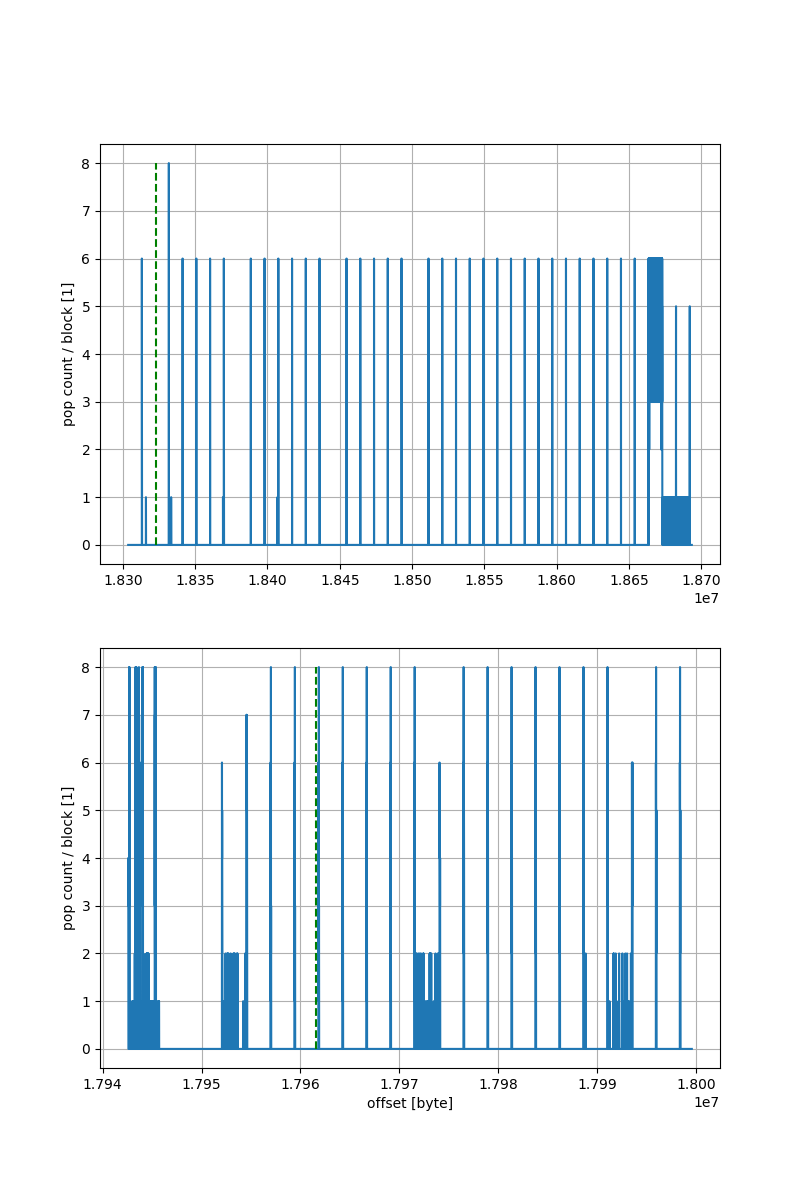

In [9]:
fig = plt.figure(figsize=(8, 12))
ax1, ax2 = fig.subplots(2, 1)  # , sharex=True)

N = 8
fn1 = "../../bitstreams/comp/T31_output_addr_0x200000.jic"
fn2 = "../../bitstreams/comp/T31_output_addr_0x200000_comp.jic"

plot_bitstream(
    ax1,
    fn1,
    N=N,
    lower_lim=file_info[fn1].last_block_start - BLK_SIZE,
    upper_lim=file_info[fn1].last_block_start + 40 * BLK_SIZE,
    bits=True
)

plot_bitstream(
    ax2,
    fn2,
    N=N,
    lower_lim=file_info[fn2].last_block_start - BLK_SIZE,
    upper_lim=file_info[fn2].last_block_start + 5 * BLK_SIZE,
    bits=True
)

ax1.plot(
    [
        (file_info[fn1].last_block_start + BLK_SIZE)*8,
        (file_info[fn1].last_block_start + BLK_SIZE)*8,
    ],
    [0, N],
    "--g",
)

ax2.plot(
    [
        (file_info[fn2].last_block_start + BLK_SIZE)*8,
        (file_info[fn2].last_block_start + BLK_SIZE)*8,
    ],
    [0, N],
    "--g",
)

ax1.grid()
ax1.set_ylabel("pop count / block [1]")
ax2.grid()
ax2.set_ylabel("pop count / block [1]")
ax2.set_xlabel("offset [byte]")


# ax.legend()

# ax.set_title("Factory image vs reference designs")

None

In [10]:
addrs = [
    2291478,
    2292666,
    2293854,
    2293854+1188*1,
    2293854+1188*2,
    2293854+1188*3,
]
addrs = np.array(addrs, dtype=int)

jic = JicBitstream("../../bitstreams/comp/T31_output_addr_0x200000.jic").jic_uint8

for addr in addrs:
    print(vhex(jic[addr-1:addr+10]))
    
print(np.diff(addrs))

['0x0' '0xcd' '0x91' '0xff' '0x25' '0x0' '0x0' '0x4' '0x3' '0x0' '0x0']
['0x0' '0x63' '0x10' '0xf5' '0xa1' '0x0' '0x0' '0x37' '0x24' '0x0' '0x0']
['0x0' '0xb6' '0xf9' '0x81' '0x8b' '0x0' '0x0' '0x2f' '0xe8' '0x0' '0x0']
['0x0' '0xb6' '0xf9' '0x81' '0x8b' '0x0' '0x0' '0x2f' '0xe8' '0x0' '0x0']
['0x0' '0x4b' '0x8b' '0x1d' '0xfc' '0x0' '0x0' '0x99' '0x46' '0xc1' '0x68']
['0x0' '0x0' '0x0' '0x0' '0x0' '0x0' '0x0' '0x0' '0x0' '0x0' '0x0']
[1188 1188 1188 1188 1188]


In [12]:
JIC_ROI_START = 2291478
JIC_ROI_SIZE = 1188*20

jic_roi = jic[JIC_ROI_START:JIC_ROI_START+JIC_ROI_SIZE]
locs = np.where(jic_roi != 0)[0]

prev_loc = 0

for loc in locs:
    should_print = True
    for i in range(1, 8):
        if loc-i in locs:
            should_print = False
    if should_print:
        print(f"0x{loc:06x}", f"{loc-prev_loc:6}",vhex(jic_roi[loc:loc+8]))
        prev_loc = loc


0x000000      0 ['0xcd' '0x91' '0xff' '0x25' '0x0' '0x0' '0x4' '0x3']
0x0000c8    200 ['0x1' '0x0' '0x0' '0x0' '0x0' '0x0' '0x0' '0x0']
0x0004a4    988 ['0x63' '0x10' '0xf5' '0xa1' '0x0' '0x0' '0x37' '0x24']
0x000948   1188 ['0xb6' '0xf9' '0x81' '0x8b' '0x0' '0x0' '0x2f' '0xe8']
0x000dec   1188 ['0xb6' '0xf9' '0x81' '0x8b' '0x0' '0x0' '0x2f' '0xe8']
0x001248   1116 ['0x4' '0x0' '0x0' '0x0' '0x0' '0x0' '0x0' '0x0']
0x001290     72 ['0x4b' '0x8b' '0x1d' '0xfc' '0x0' '0x0' '0x99' '0x46']
0x001bac   2332 ['0xb6' '0xf9' '0x81' '0x8b' '0x0' '0x0' '0xc5' '0x45']
0x002050   1188 ['0xb6' '0xf9' '0x81' '0x8b' '0x0' '0x0' '0x2f' '0xe8']
0x0024ac   1116 ['0x4' '0x0' '0x0' '0x0' '0x0' '0x0' '0x0' '0x0']
0x0024f4     72 ['0x4b' '0x8b' '0x1d' '0xfc' '0x0' '0x0' '0x99' '0x46']
0x002998   1188 ['0xb6' '0xf9' '0x81' '0x8b' '0x0' '0x0' '0x2f' '0xe8']
0x002e3c   1188 ['0xb6' '0xf9' '0x81' '0x8b' '0x0' '0x0' '0x2f' '0xe8']
0x0032e0   1188 ['0xb6' '0xf9' '0x81' '0x8b' '0x0' '0x0' '0x2f' '0xe8']
0x003bfc   2

In [13]:
class JicBlockIterator:
    MAGIC_SIZE = 4
    HEADER_SIZE = 77660
    BLK_SIZE = 1188
    BLK_SIZE_ALT = 2332
    BLK_SIZE_ALT2 = 192
    BLK_SIZE_ALT3 = 12

    ALT_BLK_HEADER = np.array([0xC1, 0x68, 0x3, 0x0], dtype=np.uint8)
    ALT2_BLK_HEADER = np.array([0xEC, 0x64, 0x0, 0x0], dtype=np.uint8)
    ALT3_BLK_HEADER = np.array([0xAE, 0xFB, 0x0, 0x0], dtype=np.uint8)

    vhex = np.vectorize(hex)
    vchr = np.vectorize(chr)

    def __init__(self, jic: JicBitstream, verbose=False):
        self.done = False
        self.verbose = verbose
        self._bs = jic.jic_uint8
        self._loc = jic.find_jjjj_seqs()[0]

        magic = self.get(self.MAGIC_SIZE)
        if self.verbose:
            print("magic =", self.vchr(magic))

        _ = self.get(self.HEADER_SIZE)

    def get(self, size: int) -> np.array:
        tmp = self.peek(size)
        self._loc += size
        return tmp

    def peek(self, size: int) -> np.array:
        return self._bs[self._loc : self._loc + size]

    def __iter__(self):
        return self

    def __next__(self):
        if self.done:
            raise StopIteration

        blk_header = self.peek(4)
        loc = self._loc

        if np.all(blk_header == self.ALT_BLK_HEADER):
            blk = self.get(self.BLK_SIZE_ALT)
        elif np.all(blk_header == self.ALT2_BLK_HEADER):
            blk = self.get(self.BLK_SIZE_ALT2)
        elif np.all(blk_header == self.ALT3_BLK_HEADER):
            blk = self.get(self.BLK_SIZE_ALT3)
            self.done = True
        else:
            blk = self.get(self.BLK_SIZE)

        chksum = Crc16Modbus.calc(blk)
        if self.verbose:
            print(
                "loc",
                loc,
                ", blk header =",
                blk_header,
                ", checksum = ",
                chksum,
                ", len = ",
                len(blk),
            )

        assert chksum == 0
        return blk

In [14]:
blkiter = JicBlockIterator(
    JicBitstream("../../bitstreams/comp/T31_output_addr_0x200000.jic")
)

for blk in blkiter:
    print(blk)

[  0   0   0 ...   0  16 127]
[  0   0   0 ...   0 140 156]
[  0   0   0 ...   0 188 115]
[  0   0   0 ...   0 117 247]
[ 0  0  0 ...  0 54 58]
[  0   0   0 ...   0 143  68]
[  0   0   0 ...   0 197 180]
[  0   0   0 ...   0 130 133]
[  0   0   0 ...   0 175  76]
[ 0  0  0 ...  0 12 25]
[  0   0   0 ...   0 123 255]
[  0   0   0 ...   0 203  99]
[  0   0   0 ...   0 135 213]
[  0   0   0 ...   0 209 117]
[  0   0   0 ...   0 215 162]
[  0   0   0 ...   0 142  70]
[  0   0   0 ...   0 218  81]
[  0   0   0 ...   0 212 102]
[  0   0   0 ...   0 133 157]
[  0   0   0 ...   0  25 130]
[ 0  0  0 ...  0 66 36]
[  0   0   0 ...   0 238  26]
[ 0  0  0 ...  0 39  6]
[  0   0   0 ...   0 236 206]
[ 0  0  0 ...  0 25 43]
[  0   0   0 ...   0 182  65]
[  0   0   0 ...   0 172  79]
[  0   0   0 ...   0 188 146]
[  0   0   0 ...   0 139 171]
[ 0  0  0 ...  0 39 85]
[  0   0   0 ...   0  13 199]
[ 0  0  0 ...  0 21 19]
[  0   0   0 ...   0 170  39]
[  0   0   0 ...   0 138 120]
[  0   0   0 ...   0 1

[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[193 104   3 ...   0 197  69]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[193 104   3 ...   0 197  69]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 160]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0  

[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0  

[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[193 104   3 ...   0 197  69]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[193 104   3 ...   0 197  69]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[193 104   3 ...   0 197  69]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[193 104   3 ...   0 197  69]
[  0   0   0 ...   0  47 232]
[  0   0  

[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0 114 253]
[  0   0   0 ...   0 116   2]
[  0   0   0 ...   0 247  89]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[193 104   3 ...   0 197  69]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[193 104   3 ...   0 197  69]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0  

[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0  

[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0  

[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[193 104   3 ...   0 197  69]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[193 104   3 ...   0 197  69]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 160]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0  

[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[193 104   3 ...   0 197  69]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[193 104   3 ...   0 197  69]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 160]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0  

[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0 151  12]
[  0   0   0 ...   0 122 210]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  68 100]
[  0   0   0 ...   0  49 154]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0   7 160]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[193 104   3 ...   0 197  69]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[193 104   3 ...   0 197  69]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[193 104   3 ...   0 197  69]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[193 104   3 ...   0 197  69]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0  

[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0  

[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0  

[  0   0   0 ...   0 151  12]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0 122 210]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  68 100]
[  0   0   0 ...   0  49 154]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0   7 160]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[193 104   3 ...   0 197  69]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[193 104   3 ...   0 197  69]
[  0   0   0 ...   0  47 232]
[  0   0  

[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0  

[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0  

[  0   0   0 ...   0  47 232]
[193 104   3 ...   0 197  69]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[193 104   3 ...   0 197  69]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 160]
[  0   0   0 ...   0 220  68]
[  0   0   0 ...   0 151  12]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0  

[193 104   3 ...   0 197  69]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 160]
[  0   0   0 ...   0 220  68]
[  0   0   0 ...   0 151  12]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0  

[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0  

[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0  

[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  68 100]
[  0   0   0 ...   0  49 154]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0   7 160]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[193 104   3 ...   0 197  69]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[193 104   3 ...   0 197  69]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[193 104   3 ...   0 197  69]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[193 104   3 ...   0 197  69]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0  

[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0 151  12]
[  0   0   0 ...   0 122 210]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  68 100]
[  0   0   0 ...   0  49 154]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0   7 160]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[193 104   3 ...   0 197  69]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[193 104   3 ...   0 197  69]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[193 104   3 ...   0 197  69]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[193 104   3 ...   0 197  69]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0  

[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0  

[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0 122 210]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  68 100]
[  0   0   0 ...   0  49 154]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0   7 160]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[193 104   3 ...   0 197  69]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[193 104   3 ...   0 197  69]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[193 104  

[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0 122 210]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  68 100]
[  0   0   0 ...   0  49 154]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0   7 160]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[193 104   3 ...   0 197  69]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[193 104   3 ...   0 197  69]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0  

[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0  

[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0  

[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0 114 253]
[  0   0   0 ...   0 116   2]
[  0   0   0 ...   0 247  89]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[193 104   3 ...   0 197  69]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[193 104   3 ...   0 197  69]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[193 104   3 ...   0 197  69]
[  0   0  

[  0   0   0 ...   0 220  68]
[  0   0   0 ...   0 182  40]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0 148   5]
[  0   0   0 ...   0 122 210]
[ 0  0  0 ...  0 78 52]
[  0   0   0 ...   0  68 100]
[  0   0   0 ...   0  49 154]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0   7 160]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[193 104   3 ...   0 197  69]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[193 104   3 ...   0 197  69]
[  0   0   0 ...

[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0  

[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  14 204]
[  0   0   0 ...   0 148   5]
[  0   0   0 ...   0  47 232]
[ 0  0  0 ...  0 78 52]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...

[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[193 104   3 ...   0 197  69]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0 105 251]
[  0   0   0 ...   0  42 240]
[  0   0   0 ...   0 201  97]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0  

[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0  

[193 104   3 ...   0 197  69]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[193 104   3 ...   0 197  69]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[193 104   3 ...   0 197  69]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[193 104   3 ...   0 197  69]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0  

[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0  

[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0  

[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 160]
[  0   0   0 ...   0 220  68]
[  0   0   0 ...   0 151  12]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0 122 210]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  68 100]
[  0   0   0 ...   0  49 154]
[  0   0  

[193 104   3 ...   0 197  69]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[193 104   3 ...   0 197  69]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  71 107]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  33 194]
[  0   0   0 ...   0  47 232]
[  0   0  

[193 104   3 ...   0 197  69]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[193 104   3 ...   0 197  69]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[193 104   3 ...   0 197  69]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[193 104   3 ...   0 197  69]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[193 104   3 ...   0 197  69]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[193 104   3 ...   0 197  69]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[193 104   3 ...   0 197  69]
[  0   0   0 ...   0  47 232]
[  0   0  

[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0  

[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0  

[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[193 104   3 ...   0 197  69]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 160]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  14 204]
[  0   0   0 ...   0 148   5]
[  0   0   0 ...   0  47 232]
[ 0  0  0 ...  0 78 52]
[  0   0   0 ...   0 220  68]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...

[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[193 104   3 ...   0 197  69]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[193 104   3 ...   0 197  69]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 160]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  14 204]
[  0   0   0 ...   0 148   5]
[  0   0   0 ...   0  47 232]
[ 0  0  0 

[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0  

[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0  

[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 160]
[  0   0   0 ...   0 220  68]
[  0   0   0 ...   0 151  12]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0 122 210]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  68 100]
[  0   0   0 ...   0  49 154]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0   7 160]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[193 104   3 ...   0 197  69]
[  0   0  

[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 160]
[  0   0   0 ...   0 220  68]
[  0   0   0 ...   0 151  12]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0 122 210]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  68 100]
[  0   0   0 ...   0  49 154]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0   7 160]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[193 104   3 ...   0 197  69]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0  

[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 160]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0 220  68]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0  

[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0  

[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0  

[193 104   3 ...   0 197  69]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[193 104   3 ...   0 197  69]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[193 104   3 ...   0 197  69]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[193 104   3 ...   0 197  69]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0  

[  0   0   0 ...   0  68 100]
[  0   0   0 ...   0  49 154]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0   7 160]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[193 104   3 ...   0 197  69]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[193 104   3 ...   0 197  69]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[193 104   3 ...   0 197  69]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[193 104   3 ...   0 197  69]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0  

[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0  

[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0  

[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0 114 253]
[  0   0   0 ...   0 116   2]
[  0   0   0 ...   0 247  89]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[193 104   3 ...   0 197  69]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[193 104   3 ...   0 197  69]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0  

[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 160]
[  0   0   0 ...   0 220  68]
[  0   0   0 ...   0 151  12]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0  

[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0  

[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0  

[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0 151  12]
[  0   0   0 ...   0 122 210]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  68 100]
[  0   0   0 ...   0  49 154]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0   7 160]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[193 104   3 ...   0 197  69]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[193 104   3 ...   0 197  69]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[193 104   3 ...   0 197  69]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[193 104   3 ...   0 197  69]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0  

[  0   0   0 ...   0   7 160]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[193 104   3 ...   0 197  69]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[193 104   3 ...   0 197  69]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[193 104   3 ...   0 197  69]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[193 104   3 ...   0 197  69]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0  

[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0  

[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0  

[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0 220  68]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0 151  12]
[  0   0   0 ...   0 122 210]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  68 100]
[  0   0   0 ...   0  49 154]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0   7 160]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[193 104   3 ...   0 197  69]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[193 104   3 ...   0 197  69]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0  

[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0  

[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0  

[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 160]
[  0   0   0 ...   0 220  68]
[  0   0   0 ...   0 151  12]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0 122 210]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  68 100]
[  0   0  

[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[193 104   3 ...   0 197  69]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[193 104   3 ...   0 197  69]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 160]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0  

[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[193 104   3 ...   0 197  69]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[193 104   3 ...   0 197  69]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[193 104   3 ...   0 197  69]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 160]
[  0   0  

[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0  

[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[193 104   3 ...   0 197  69]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[193 104   3 ...   0 197  69]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[193 104   3 ...   0 197  69]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[193 104   3 ...   0 197  69]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0  

[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0 114 253]
[  0   0   0 ...   0 116   2]
[  0   0   0 ...   0 247  89]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[193 104   3 ...   0 197  69]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[193 104   3 ...   0 197  69]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[193 104   3 ...   0 197  69]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[193 104   3 ...   0 197  69]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0  

[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0  

[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0   0 ...   0 241 188]
[  0   0  

[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 160]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0 220  68]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0 151  12]
[  0   0   0 ...   0 122 210]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0  68 100]
[  0   0   0 ...   0  49 154]
[  0   0   0 ...   0  47 232]
[  0   0   0 ...   0   7 160]
[  0   0  